In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

draft_df = pd.read_csv("main-big-2017-s-clean.csv")
# draft_df.drop(['Unnamed: 0'], axis = 1, inplace = True)
# set some plotting aesthetics, similar to ggplot
# sns.set(palette = "colorblind", font_scale = 1.35, 
#         rc = {"figure.figsize": (12,9), "axes.facecolor": ".92"})
# draft_dfs=draft_df.head(10000)
# draft_df[('duration','retired')]

In [312]:
# keplar object
kmf = KaplanMeierFitter()
kmf.fit(durations = draft_dfs.duration, event_observed = draft_dfs.retired)

<lifelines.KaplanMeierFitter: fitted with 2797 observations, 215 censored>

In [313]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0,215,0,215,2797,2797
1,408,408,0,0,2582
2,409,409,0,0,2174
3,401,401,0,0,1765
4,378,378,0,0,1364
5,283,283,0,0,986
6,218,218,0,0,703
7,189,189,0,0,485
8,139,139,0,0,296


In [314]:
# get the values for time = 0 from the survival table
event_at_0 = kmf.event_table.iloc[0, :]
# now calculate the survival probability for t = 0
surv_for_0 =  (event_at_0.at_risk - event_at_0.observed) / event_at_0.at_risk
surv_for_0

1.0

In [315]:
# Calculate the survival probability for t = 1
event_at_1 = kmf.event_table.iloc[1, :]
surv_for_1 =  (event_at_1.at_risk - event_at_1.observed) / event_at_1.at_risk
surv_for_1

0.8419829589465531

In [316]:
# Calculate the survival probability for t = 2
event_at_2 = kmf.event_table.iloc[2, :]
surv_for_2 =  (event_at_2.at_risk - event_at_2.observed) / event_at_2.at_risk
surv_for_2

0.8118675252989881

In [317]:
# The probability that an NFL player has a career longer than 2 years
surv_after_2 = surv_for_0 * surv_for_1 * surv_for_2
surv_after_2

0.6835786212238575

In [318]:
kmf.predict(2)

0.6835786212238574

In [319]:
kmf.predict([1,3,5,10])

1     0.841983
3     0.528273
5     0.272270
10    0.011619
Name: KM_estimate, dtype: float64

In [320]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
1.0,0.841983
2.0,0.683579
3.0,0.528273
4.0,0.381875
5.0,0.272270
6.0,0.187839
7.0,0.114640
8.0,0.060806


In [345]:
kmf.median_

4.0

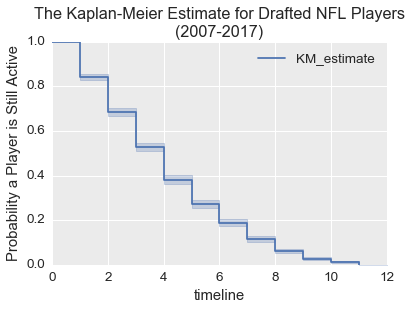

In [360]:
# plot the KM estimate
kmf.plot()
# Add title and y-axis label
plt.title("The Kaplan-Meier Estimate for Drafted NFL Players\n(2007-2017)")
plt.ylabel("Probability a Player is Still Active")
plt.show()

In [323]:
draft_df.Pos.unique() # check out all the different positions

array(['QB', 'WR', 'T', 'DE', 'DB', 'RB', 'DT', 'LB', 'G', 'TE', 'C', 'P',
       'K', 'FB', 'OL', 'DL', 'NT', 'OLB', 'CB', 'FS', 'ILB', 'SS', 'S',
       'LS'], dtype=object)

In [324]:
draft_df.Pos.value_counts() # get a count for each position

DB     421
WR     354
LB     276
DE     248
RB     242
DT     215
T      205
TE     163
G      141
QB     128
CB      87
C       63
OLB     56
OL      40
S       31
ILB     23
K       22
FB      19
P       18
SS      13
FS      12
NT      11
DL       6
LS       3
Name: Pos, dtype: int64

In [325]:
# Relabel/Merge some of the positions
# Set all HBs to RB
draft_df.loc[draft_df.Pos == "HB", "Pos"] = "RB"

# Set all Safeties and Cornernbacks to DBs
draft_df.loc[draft_df.Pos.isin(["SS", "FS", "S", "CB"]), "Pos"] = "DB"

# Set all types of Linebackers to LB
draft_df.loc[draft_df.Pos.isin(["OLB", "ILB"]), "Pos"] = "LB"

In [326]:
# drop players from the following positions [FL, E, WB, KR, LS, OL]
# get the row indices for players with undesired postions
idx = draft_df.Pos.isin(["FL", "E", "WB", "KR", "LS", "DL", "OL"])
# keep the players that don't have the above positions
draft_df_2 = draft_df.loc[~idx, :]

In [327]:
# check the number of positions in order to decide
# on the plotting grid dimiensions
len(draft_df_2.Pos.unique())

15

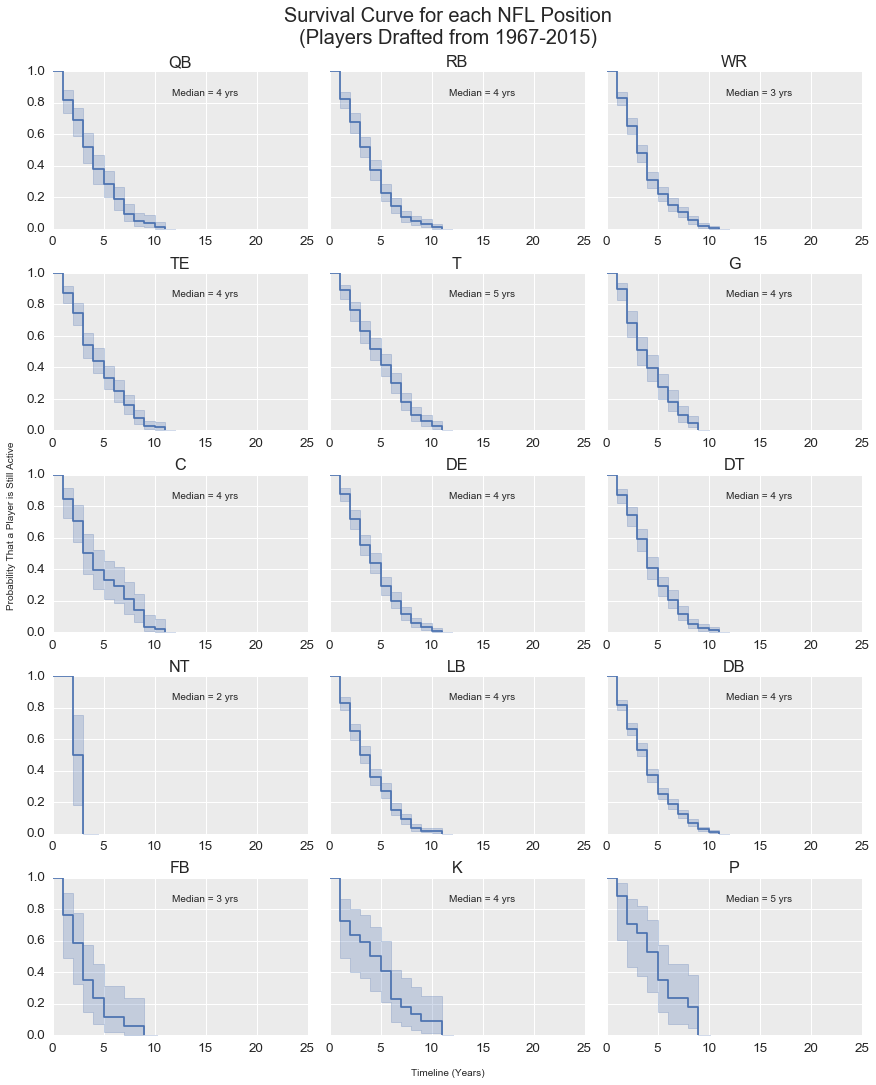

In [361]:
# create a new KMF object
kmf_by_pos = KaplanMeierFitter()

duration = draft_df_2.duration
observed = draft_df_2.retired

# Set the order that the positions will be plotted
positions = ["QB", "RB", "WR",
             "TE", "T", "G", 
             "C", "DE", "DT", 
             "NT", "LB", "DB",
             "FB", "K", "P"]

# Set up the the 5x3 plotting grid by creating figure and axes objects
# Set sharey to True so that each row of plots share the left most y-axis labels
fig, axes = plt.subplots(nrows = 5, ncols = 3, sharey = True,
                         figsize=(12,15))

# flatten() creates a 1-D array of the individual axes (or subplots)
# that we will plot on in our grid
# We zip together the two 1-D arrays containing the positions and axes
# so we can iterate over each postion and plot its KM estimate onto 
# its respective axes
for pos, ax in zip(positions, axes.flatten()):
    # get indices for players with the matching position label
    idx = draft_df_2.Pos == pos
    # fit the kmf for the those players
    kmf_by_pos.fit(duration[idx], observed[idx])
    # plot the KM estimate for that position on its respective axes
    kmf_by_pos.plot(ax=ax, legend=False)
    # place text indicating the median for the position
    # the xy-coord passed in represents the fractional value for each axis
    # for example (.5, .5) places text at the center of the plot
    ax.annotate("Median = {:.0f} yrs".format(kmf_by_pos.median_), xy = (.47, .85), 
                xycoords = "axes fraction")
    # get rid the default "timeline" x-axis label set by kmf.plot() 
    ax.set_xlabel("")
    # label each plot by its position
    ax.set_title(pos)
    # set a common x and y axis across all plots
    ax.set_xlim(0,25)
    ax.set_ylim(0,1)

# tighten up the padding for the subplots
fig.tight_layout()

# https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots
# set a common x-axis label
fig.text(0.5, -0.01, "Timeline (Years)", ha="center")
# set a common y-axis label
fig.text(-0.01, 0.5, "Probability That a Player is Still Active", 
         va="center", rotation="vertical")
# add the title for the whole plot
fig.suptitle("Survival Curve for each NFL Position\n(Players Drafted from 1967-2015)",
             fontsize=20)
# add some padding between the title and the rest of the plot to avoid overlap
fig.subplots_adjust(top=0.92)

plt.show()

In [329]:
kmf._conditional_time_to_event_()

,KM_estimate - Conditional time remaining to event
timeline,
0.0,4.0
1.0,3.0
2.0,3.0
3.0,3.0
4.0,2.0
5.0,2.0
6.0,2.0
7.0,2.0
8.0,1.0
